In [1]:
# !pip install python-doctr
# !pip install tensorflow-addons
!nviidia-smi

/bin/bash: /home/apsisdev/anaconda3/envs/eblict/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: nviidia-smi: command not found


In [2]:
!pwd

/bin/bash: /home/apsisdev/anaconda3/envs/eblict/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/apsisdev/Downloads/Multilingual Images


In [3]:
#!ls '/home/apsisdev/Downloads/Multilingual Images/bangla/৩.ওয়_রলক'

# Dataset Link 

https://www.kaggle.com/datasets/mobassir/multilingual-document-images

In [4]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if any(gpu_devices):
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [5]:
#-*- coding: utf-8 -*-
"""
@authors:
MD.Nazmuddoha Ansary (Gmail : nazmuddoha.ansary.28@gmail.com)
Syed Mobassir (Gmail : mobassirhossen94@gmail.com)
"""
from __future__ import print_function
# ---------------------------------------------------------
# imports
# ---------------------------------------------------------
from doctr.models.detection.zoo import detection_predictor
import numpy as np
import os
from termcolor import colored
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
import pyclipper
from shapely.geometry import Polygon
import copy
from PIL import Image
from pathlib import Path   

demo = True # Make it false to run on all images
#----------------------------------detector------------------------
class Detector(object):
    def __init__(self,backbone):
        '''
            initializes a dbnet detector model
        '''
        self.det= detection_predictor(backbone,
                                    pretrained=True,
                                    assume_straight_pages=True,
                                    batch_size=2,
                                    preserve_aspect_ratio=False)
            
    def box_score_fast(self,bitmap, _box):
        '''
            box_score_fast: use bbox mean score as the mean score
        '''
        h, w = bitmap.shape[:2]
        box = _box.copy()
        xmin = np.clip(np.floor(box[:, 0].min()).astype(np.int), 0, w - 1)
        xmax = np.clip(np.ceil(box[:, 0].max()).astype(np.int), 0, w - 1)
        ymin = np.clip(np.floor(box[:, 1].min()).astype(np.int), 0, h - 1)
        ymax = np.clip(np.ceil(box[:, 1].max()).astype(np.int), 0, h - 1)

        mask = np.zeros((ymax - ymin + 1, xmax - xmin + 1), dtype=np.uint8)
        box[:, 0] = box[:, 0] - xmin
        box[:, 1] = box[:, 1] - ymin
        cv2.fillPoly(mask, box.reshape(1, -1, 2).astype(np.int32), 1)
        return cv2.mean(bitmap[ymin:ymax + 1, xmin:xmax + 1], mask)[0]


    def unclip(self,box, unclip_ratio=2.0):
        '''
            unclips a box
        '''
        poly = Polygon(box)
        distance = poly.area * unclip_ratio / poly.length
        offset = pyclipper.PyclipperOffset()
        offset.AddPath(box, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
        expanded = np.array(offset.Execute(distance))
        return expanded

    def get_mini_boxes(self,contour):
        '''
            extracts mini boxes
        '''
        if not contour.size:
            return [], 0
        bounding_box = cv2.minAreaRect(contour)
        points = sorted(list(cv2.boxPoints(bounding_box)), key=lambda x: x[0])

        index_1, index_2, index_3, index_4 = 0, 1, 2, 3
        if points[1][1] > points[0][1]:
            index_1 = 0
            index_4 = 1
        else:
            index_1 = 1
            index_4 = 0
        if points[3][1] > points[2][1]:
            index_2 = 2
            index_3 = 3
        else:
            index_2 = 3
            index_3 = 2

        box = [points[index_1], points[index_2],
            points[index_3], points[index_4]]
        return box, min(bounding_box[1])

    def boxes_from_bitmap(self, 
                          pred, 
                          bitmap, 
                          dest_width, 
                          dest_height,
                          max_candidates=1000,
                          box_thresh=0.5,
                          min_size=3):
        '''
            extracts boxes from bitmaps
        '''
        height, width = bitmap.shape
        outs = cv2.findContours((bitmap * 255).astype(np.uint8), cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        if len(outs) == 3:
            img, contours, _ = outs[0], outs[1], outs[2]
        elif len(outs) == 2:
            contours, _ = outs[0], outs[1]
        num_contours = min(len(contours),max_candidates)
        boxes = []
        scores = []
        for index in range(num_contours):
            contour = contours[index]
            points, sside = self.get_mini_boxes(contour)
            if sside < min_size:
                continue
            points = np.array(points)
            score = self.box_score_fast(pred, points.reshape(-1, 2))
            if score < box_thresh:
                continue

            box = self.unclip(points).reshape(-1, 1, 2)
            box, sside = self.get_mini_boxes(box)
            if sside < min_size + 2:
                continue
            box = np.array(box)

            box[:, 0] = np.clip(np.round(box[:, 0] / width * dest_width), 0, dest_width)
            box[:, 1] = np.clip(np.round(box[:, 1] / height * dest_height), 0, dest_height)
            boxes.append(box.astype(np.int16))
            scores.append(score)
        return np.array(boxes, dtype=np.float32), scores


    

    def sorted_boxes(self,dt_boxes,dist=10):
        """
        Sort text boxes in order from top to bottom, left to right
        args:
            dt_boxes(array):detected text boxes with shape [4, 2]
        return:
            sorted boxes(array) with shape [4, 2]
        """
        num_boxes = dt_boxes.shape[0]
        sorted_boxes = sorted(dt_boxes, key=lambda x: (x[0][1], x[0][0]))
        _boxes = list(sorted_boxes)

        for i in range(num_boxes - 1):
            if abs(_boxes[i + 1][0][1] - _boxes[i][0][1]) < dist and (_boxes[i + 1][0][0] < _boxes[i][0][0]):
                tmp = _boxes[i]
                _boxes[i] = _boxes[i + 1]
                _boxes[i + 1] = tmp
        return _boxes

    def get_rotate_crop_image(self,img, points):
        # Use Green's theory to judge clockwise or counterclockwise
        # author: biyanhua
        d = 0.0
        for index in range(-1, 3):
            d += -0.5 * (points[index + 1][1] + points[index][1]) * (
                        points[index + 1][0] - points[index][0])
        if d < 0: # counterclockwise
            tmp = np.array(points)
            points[1], points[3] = tmp[3], tmp[1]

        img_crop_width = int(
            max(
                np.linalg.norm(points[0] - points[1]),
                np.linalg.norm(points[2] - points[3])))
        img_crop_height = int(
            max(
                np.linalg.norm(points[0] - points[3]),
                np.linalg.norm(points[1] - points[2])))
        pts_std = np.float32([[0, 0], [img_crop_width, 0],
                            [img_crop_width, img_crop_height],
                            [0, img_crop_height]])
        M = cv2.getPerspectiveTransform(points, pts_std)
        dst_img = cv2.warpPerspective(
            img,
            M, (img_crop_width, img_crop_height),
            borderMode=cv2.BORDER_REPLICATE,
            flags=cv2.INTER_CUBIC)
        dst_img_height, dst_img_width = dst_img.shape[0:2]
        if dst_img_height * 1.0 / dst_img_width >= 1.5:
            dst_img = np.rot90(dst_img)
        return dst_img
        
    
    def detect(self,img,ref,debug=False,thresh=0.5):
        '''
            extract locations and crops
        '''
        
        src=np.copy(img)
        h_src,w_src,_=src.shape
        
        if debug:
            plt.figure(figsize=(10, 8))
            plt.imshow(src)
            plt.show()
        
        processed_batches = self.det.pre_processor([src])
        out = self.det.model(processed_batches[0], return_model_output=True)
        seg_map = out["out_map"]
        #seg_map = seg_map.cpu().detach().numpy()
        pred=np.squeeze(seg_map)
        bitmap = pred > thresh
        if debug:
            plt.figure(figsize=(10, 8))
            plt.imshow(bitmap)
            plt.show()
            
        
        boxes, _ = self.boxes_from_bitmap(pred, bitmap, w_src,h_src)
        
        boxes=self.sorted_boxes(boxes)

        crops=[]
        for bno in range(len(boxes)):
            tmp_box = copy.deepcopy(boxes[bno])
            img_crop = self.get_rotate_crop_image(ref,tmp_box)
            crops.append(img_crop)

        return boxes,crops

    

/home/apsisdev/anaconda3/envs/mobassir/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(



In [6]:
!nvidia-smi

/bin/bash: /home/apsisdev/anaconda3/envs/eblict/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Fri May 27 11:49:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 30%   47C    P8    28W / 370W |    262MiB / 24576MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+-----------

In [7]:
def convert_to_word_images(detector,folder,output):
    '''
    convert all the images from a particular book into cropped word
    images using db_resnet50 text detection algorithm of doctr
    args :
        detector : text detection algorithm (default db_resnet50 of doctr)
        folder   : folder loc containing all pages of given book
        output   : where the cropped word images will be saved
    '''
    
    file = Path(folder).name
    files = sorted(os.listdir(folder))
    for page, _ in enumerate(files, start=0):
        img_path=f"{folder}/{file}_page_{page}.png"
        img=cv2.imread(img_path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        boxes,crops=detector.detect(img,img,debug=True)
        i = 0
        for crop in crops:
            data = Image.fromarray(crop)
            data.save(f'{output}/{file}_page_{page}_word_{i}.png')
            i+=1
        if(demo):
            return


In [8]:
!ls '/home/apsisdev/Downloads/Multilingual Images/multilingual_images'

/bin/bash: /home/apsisdev/anaconda3/envs/eblict/lib/libtinfo.so.6: no version information available (required by /bin/bash)
arabic	bangla	english


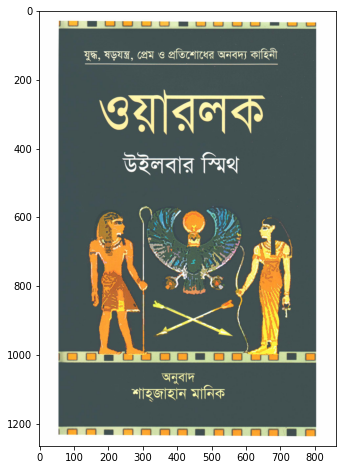

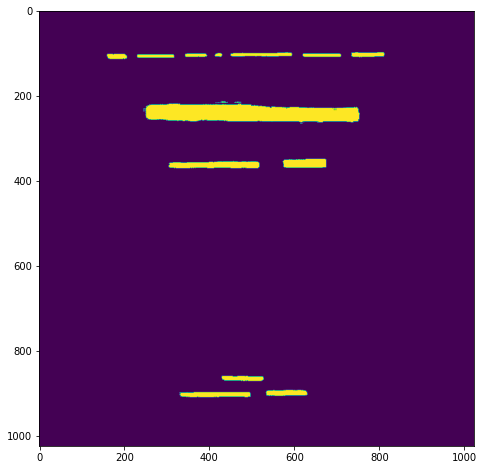

<ipython-input-5-701508fd9be1>:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xmin = np.clip(np.floor(box[:, 0].min()).astype(np.int), 0, w - 1)

<ipython-input-5-701508fd9be1>:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

FileNotFoundError: [Errno 2] No such file or directory: '/home/apsisdev/Downloads/Multilingual Images/bn_words/৩.ওয়_রলক_page_0_word_0.png'

In [9]:
%%time

detector=Detector("db_resnet50")
folder = '/home/apsisdev/Downloads/Multilingual Images/multilingual_images/bangla/৩.ওয়_রলক'
output = '/home/apsisdev/Downloads/Multilingual Images/bn_words' 

convert_to_word_images(detector=detector,folder=folder,output=output)

TypeError: Image data of dtype object cannot be converted to float

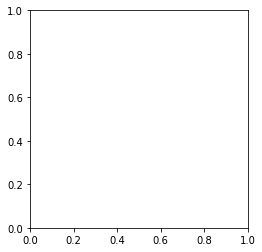

In [10]:
file = Path(folder).name
page = 3
plt.imshow(cv2.imread(f'{output}/{file}_page_{page}_word_0.png'))

In [ ]:
files = sorted(os.listdir(output))
len(files)

In [ ]:
!nvidia-smi